# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import *
from polytope_utils import *

import warnings

warnings.filterwarnings("ignore")
# np.random.seed(100)
# %load_ext autoreload
# %autoreload 2
notebook_name = "General_Polytope"

# Source Generation and Mixing Scenario

In [2]:
dim = 3

antisparse_dims = np.array([0, 1])
nonnegative_dims = np.array([2])
relative_sparse_dims_list = [np.array([0, 1]), np.array([1, 2])]
(A, b), V = generate_practical_polytope(
    dim, antisparse_dims, nonnegative_dims, relative_sparse_dims_list
)
S = generate_uniform_points_in_polytope(V, 500000)

Text(0.5, 0.98, 'Scatter Plot of Source Components')

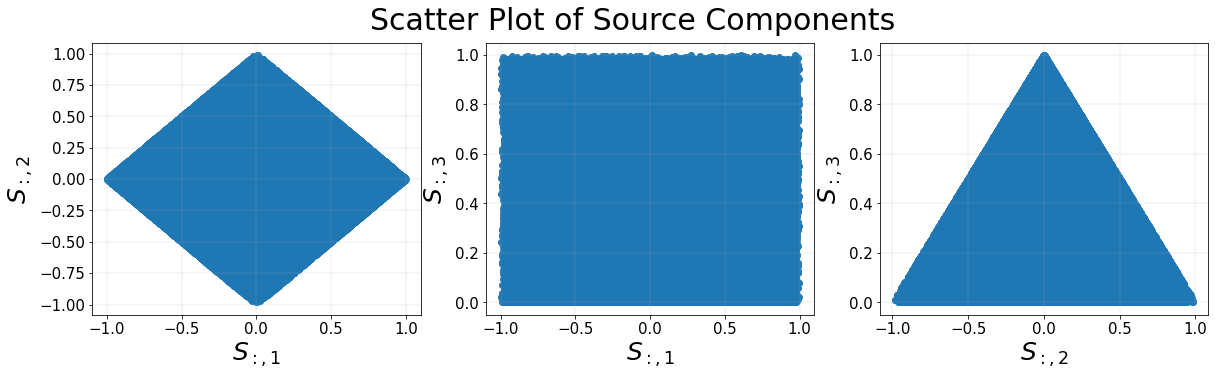

In [3]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(S[0, :], S[1, :])
plt.xlabel("$S_{:,1}$", fontsize=25)
plt.ylabel("$S_{:,2}$", fontsize=25)
plt.grid(linewidth=0.2)
plt.subplot(1, 3, 2)
plt.scatter(S[0, :], S[2, :])
plt.xlabel("$S_{:,1}$", fontsize=25)
plt.ylabel("$S_{:,3}$", fontsize=25)
plt.grid(linewidth=0.2)
plt.subplot(1, 3, 3)
plt.scatter(S[1, :], S[2, :])
plt.xlabel("$S_{:,2}$", fontsize=25)
plt.ylabel("$S_{:,3}$", fontsize=25)
plt.grid(linewidth=0.2)

plt.suptitle("Scatter Plot of Source Components", fontsize=30)
# plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 1200)

In [4]:
N = 500000
NumberofSources = 3
NumberofMixtures = 6

A = np.random.randn(NumberofMixtures, NumberofSources)
X = np.dot(A, S)

SNR = 30
Xnoisy, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Xnoisy - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99742197503291


# Visualize Generated Sources and Mixtures

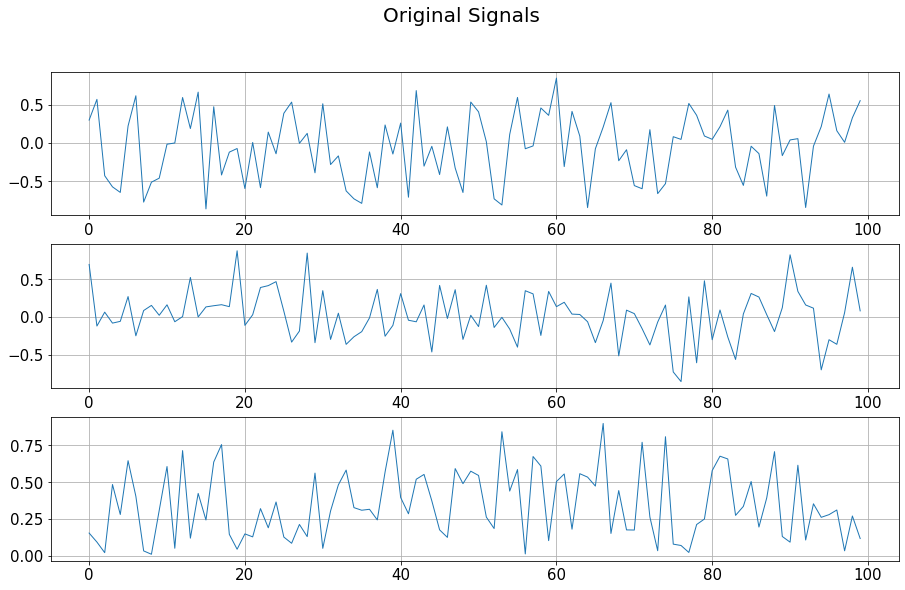

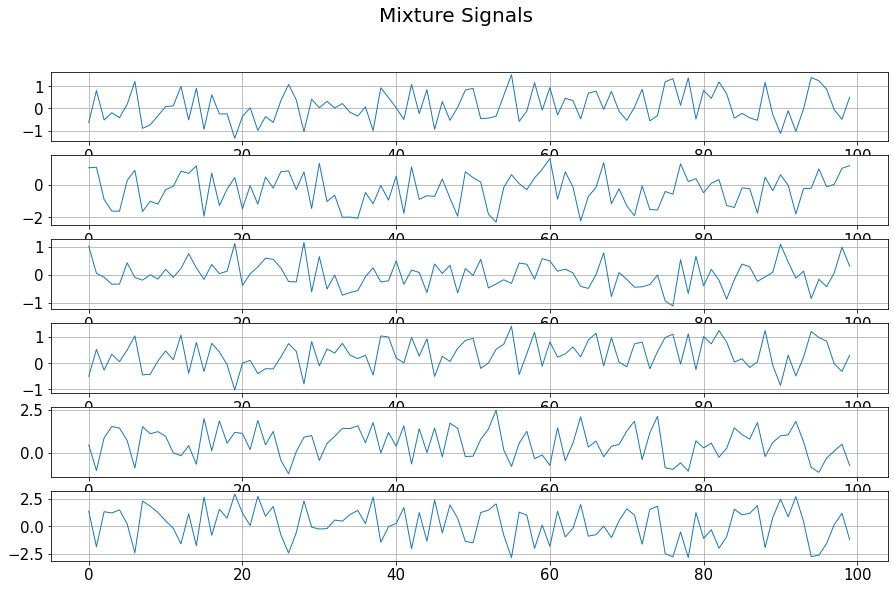

In [5]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 9), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [6]:
MUS = 0.25
gammaM_start = [MUS, MUS]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [MUS, MUS]
gammaW_stop = [1e-3, 1e-3]
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS = 3000
LayerGains = [4, 1]
LayerMinimumGains = [1e-6, 1]
LayerMaximumGains = [1e6, 1.001]
WScalings = [0.0033, 0.0033]
GamScalings = [0.02, 0.02]
zeta = 1 * 1e-4
beta = 0.5
muD = [5.725, 0]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
# OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
synaptic_lr_rule = "divide_by_log_index"
# OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
neural_loop_lr_rule = "constant"

# Run WSM Algorithm on Mixture Signals

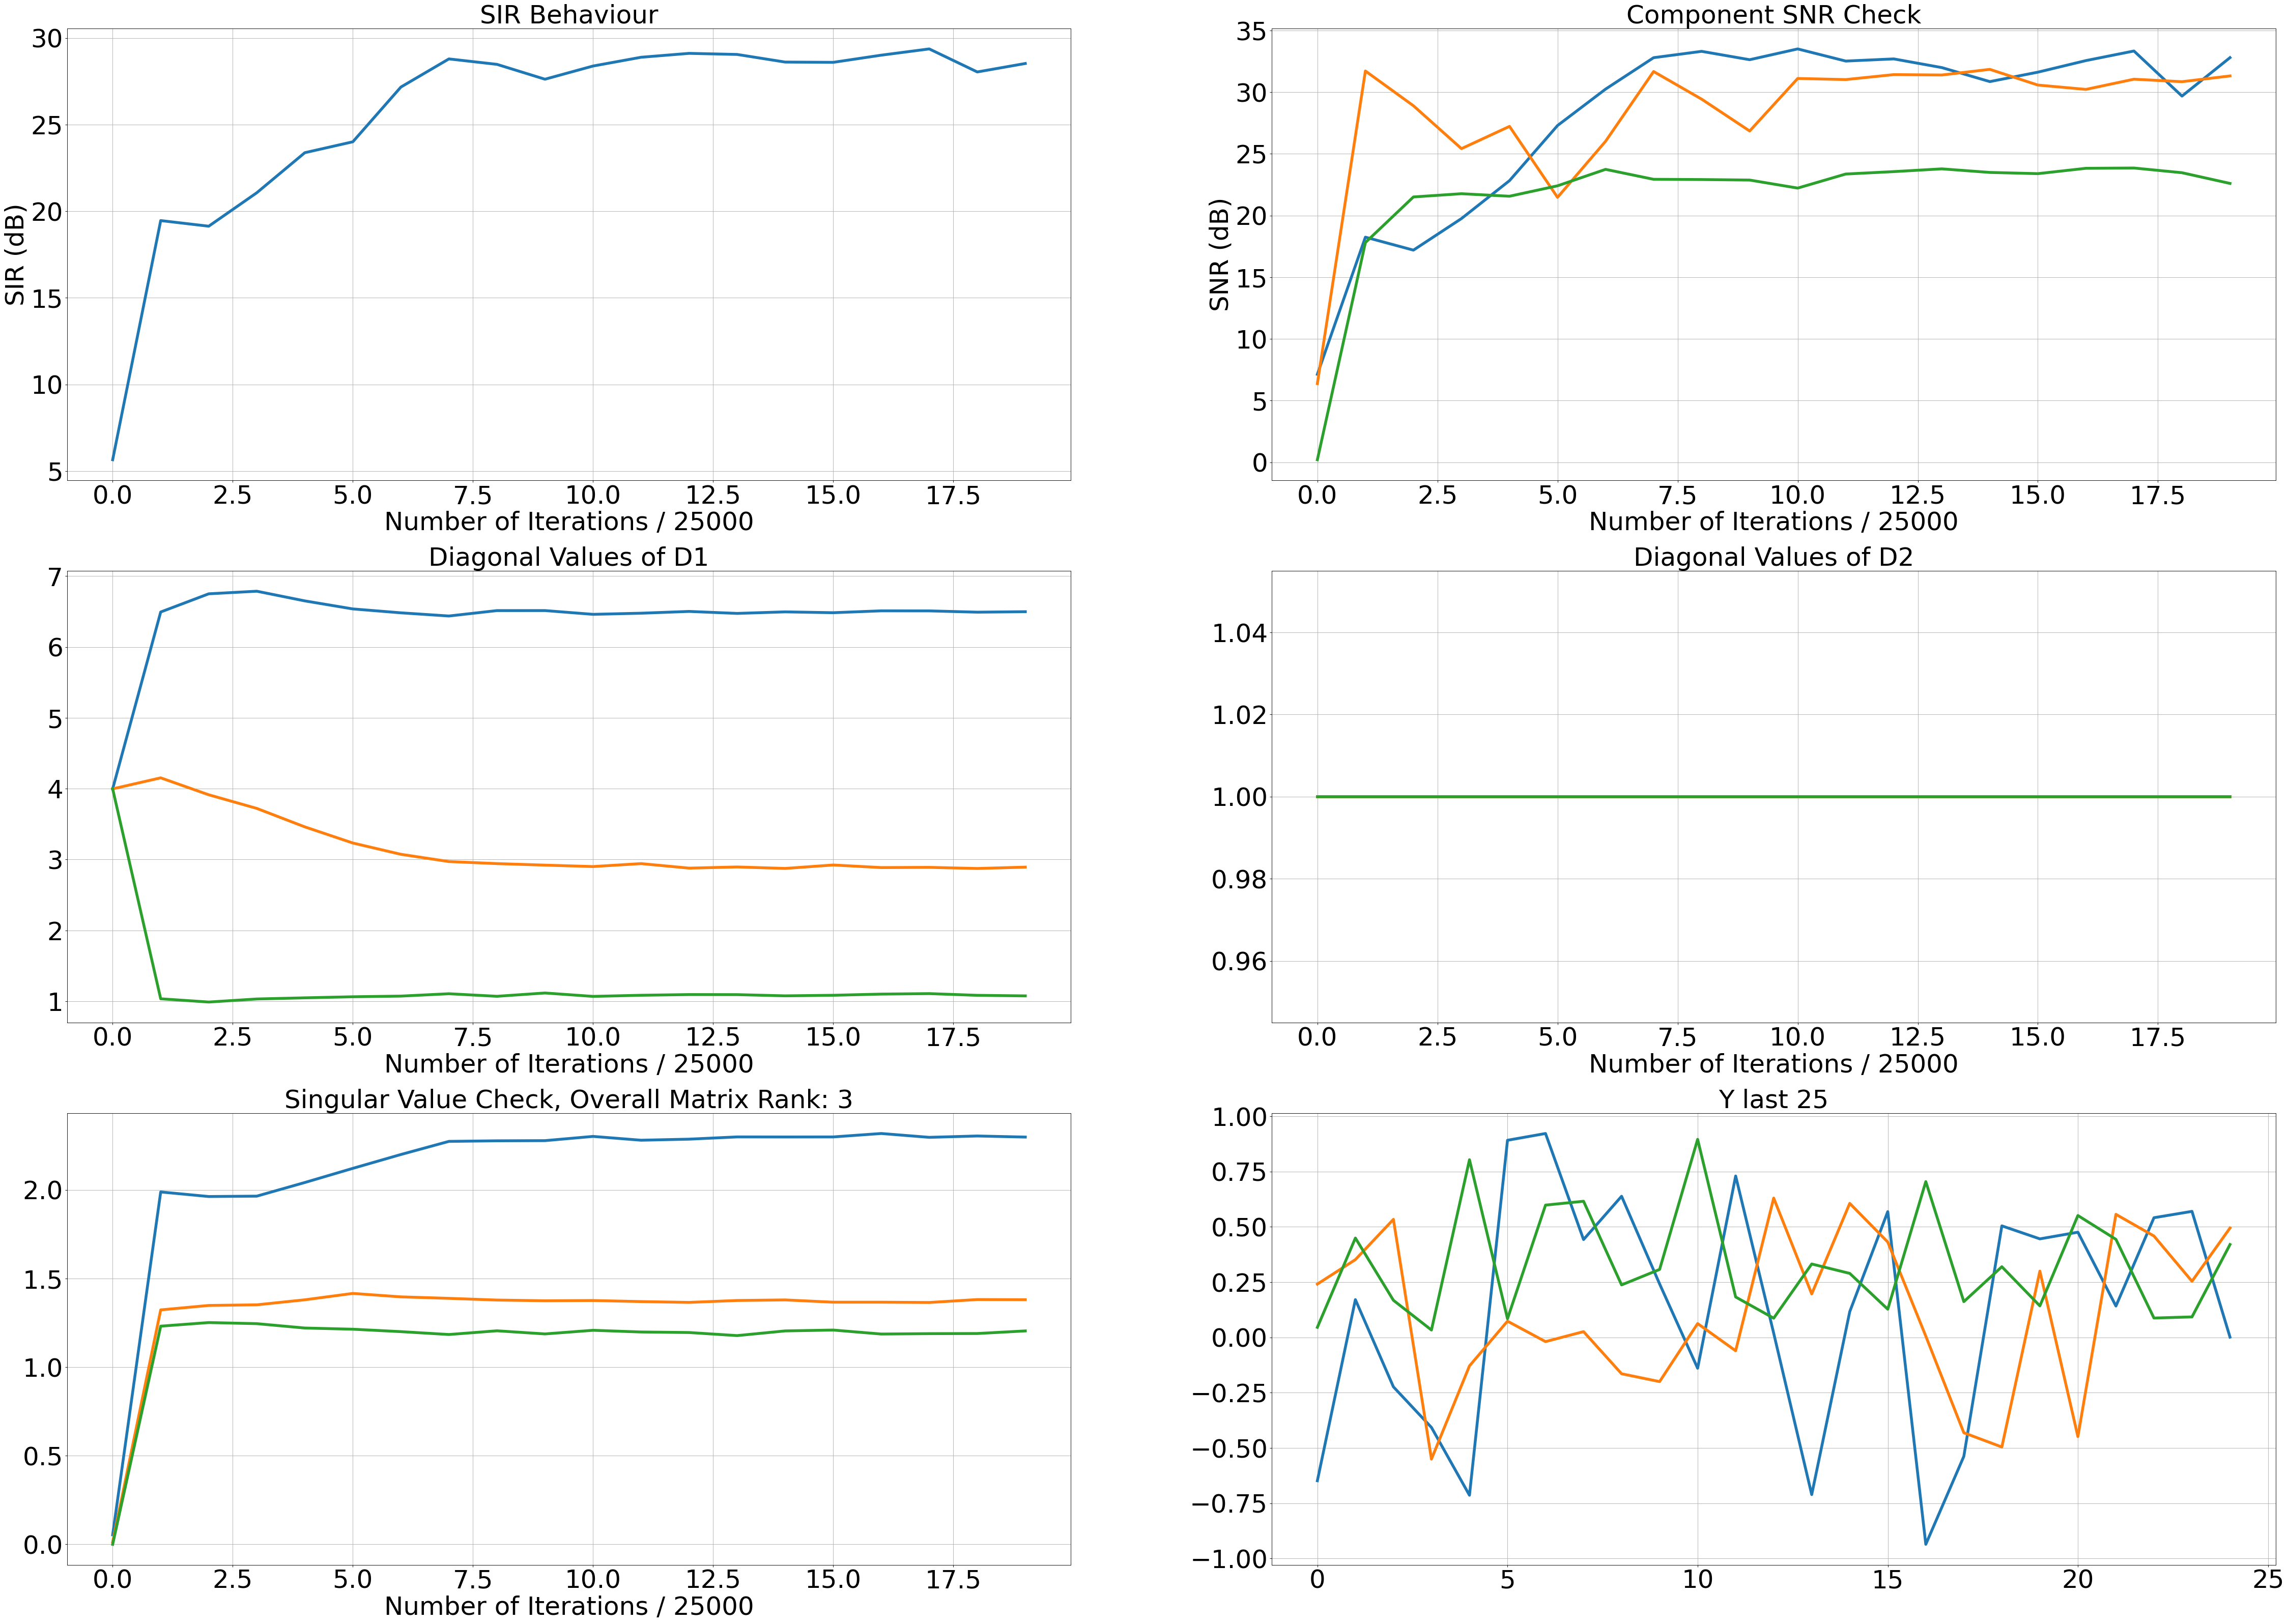

100%|██████████| 500000/500000 [17:13<00:00, 483.59it/s]


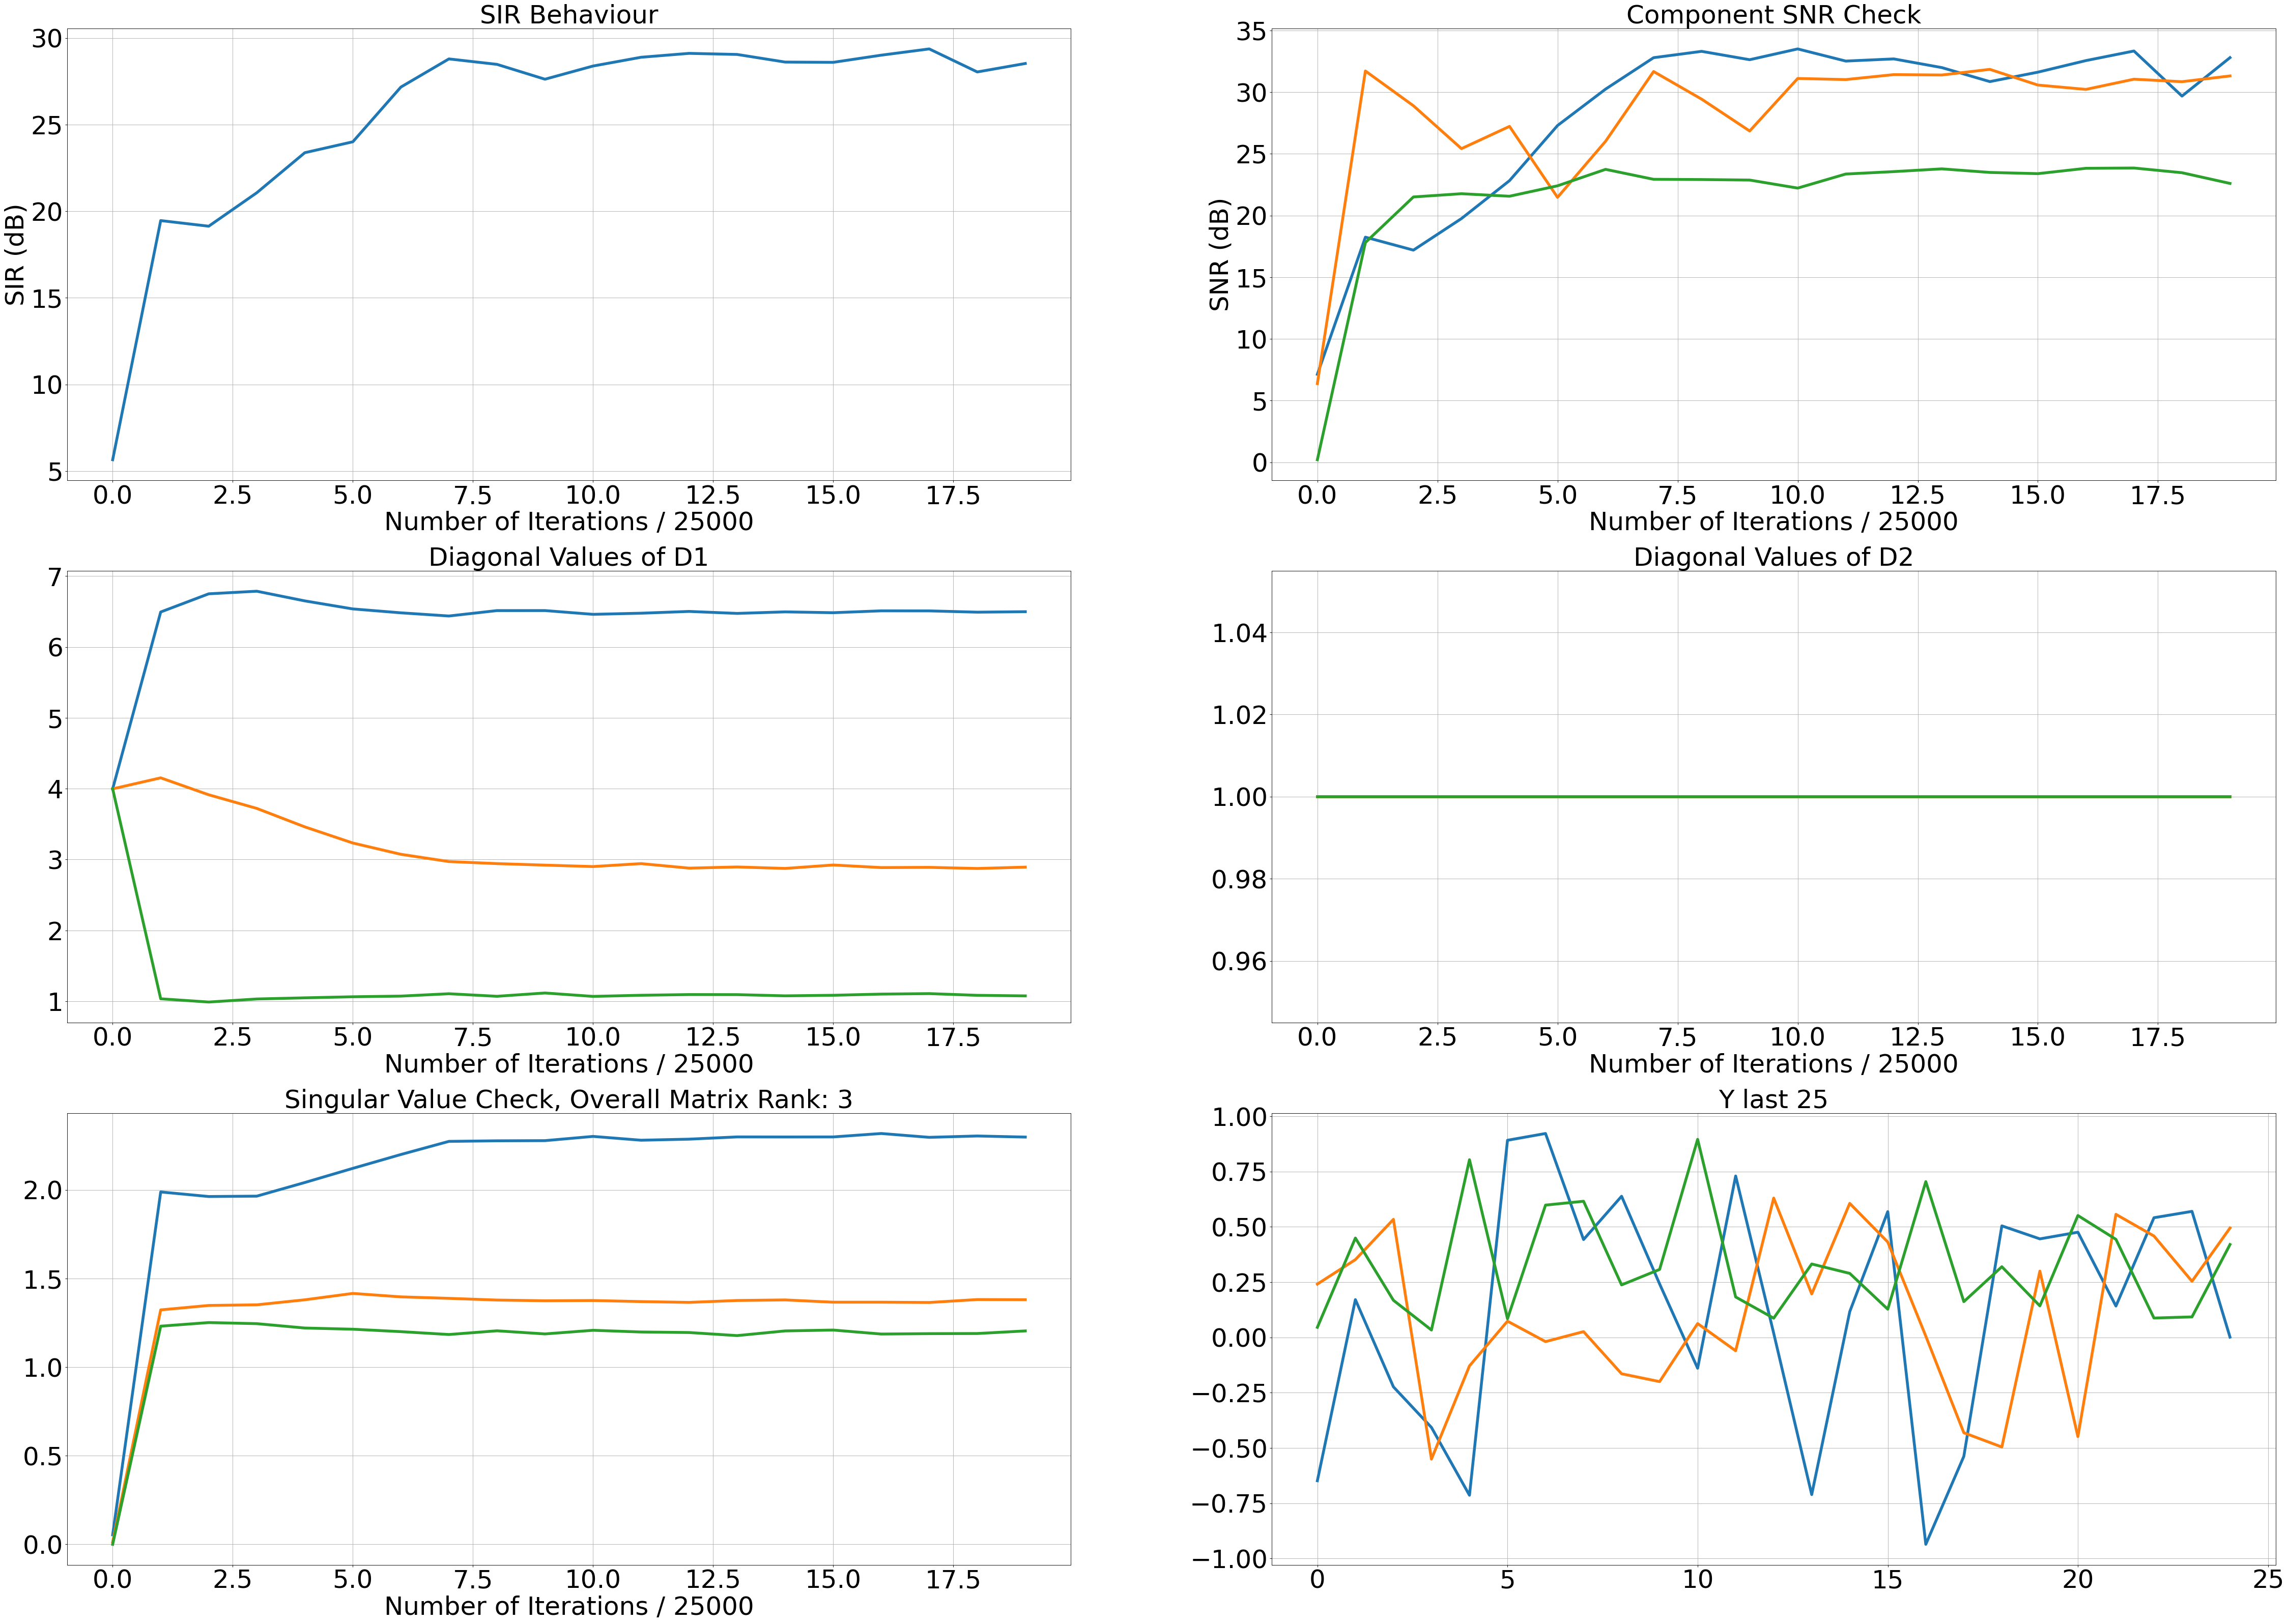

In [7]:
WSM_INPUT_STD = 0.5
XnoisyWSM = (WSM_INPUT_STD * (Xnoisy / Xnoisy.std(1)[:,np.newaxis]))
debug_iteration_point = 25000
modelWSM = OnlineWSMBSS(
                            s_dim=s_dim,
                            x_dim=x_dim,
                            h_dim=h_dim,
                            gammaM_start=gammaM_start,
                            gammaM_stop=gammaM_stop,
                            gammaW_start=gammaW_start,
                            gammaW_stop=gammaW_stop,
                            beta=beta,
                            zeta=zeta,
                            muD=muD,
                            WScalings=WScalings,
                            GamScalings=GamScalings,
                            DScalings=LayerGains,
                            LayerMinimumGains=LayerMinimumGains,
                            LayerMaximumGains=LayerMaximumGains,
                            neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
                            set_ground_truth=True,
                            S=S,
                            A=A,
                        )

modelWSM.fit_batch_general_polytope(
                                        XnoisyWSM,
                                        n_epochs=1,
                                        signed_dims=antisparse_dims,
                                        nn_dims=nonnegative_dims,
                                        sparse_dims_list=relative_sparse_dims_list,
                                        neural_lr_start=0.5,
                                        synaptic_lr_rule=synaptic_lr_rule,
                                        neural_loop_lr_rule=neural_loop_lr_rule,
                                        debug_iteration_point=debug_iteration_point,
                                        plot_in_jupyter=True,
                                    )

# Visualize SNR Convergence of Each Source Component

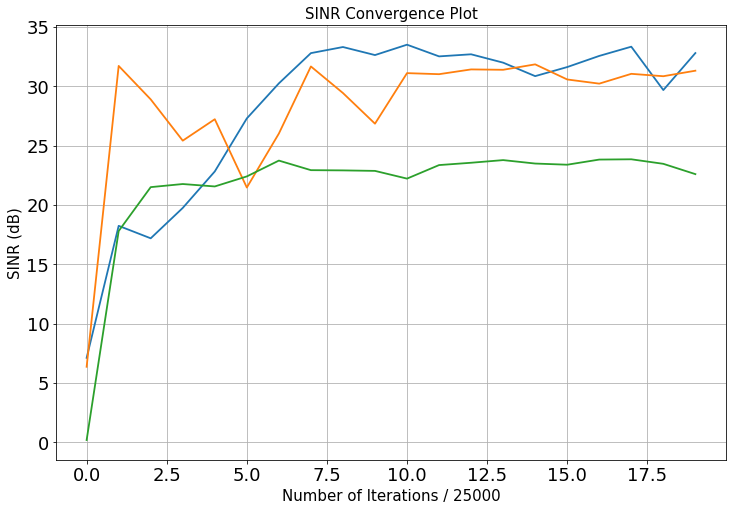

In [8]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    modelWSM.SNR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

# Calculate Resulting Component SNRs and Overall SINR

In [9]:
Wf = modelWSM.compute_overall_mapping(return_mapping=True)
Y = Wf @ XnoisyWSM
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [33.52276655 29.18063692 28.42922381]

Overall SINR : 30.105390986814434


# Vizualize Extracted Signals Compared to Original Sources

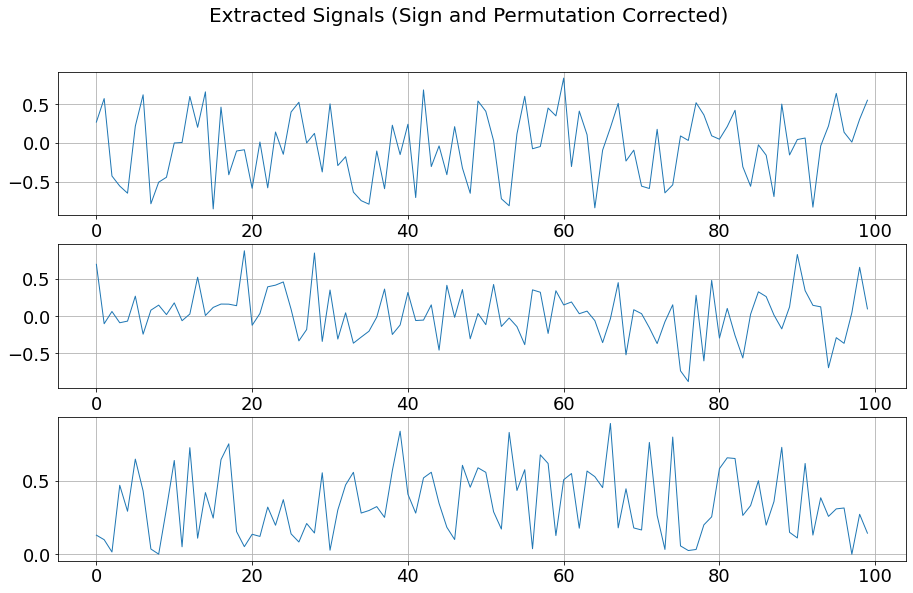

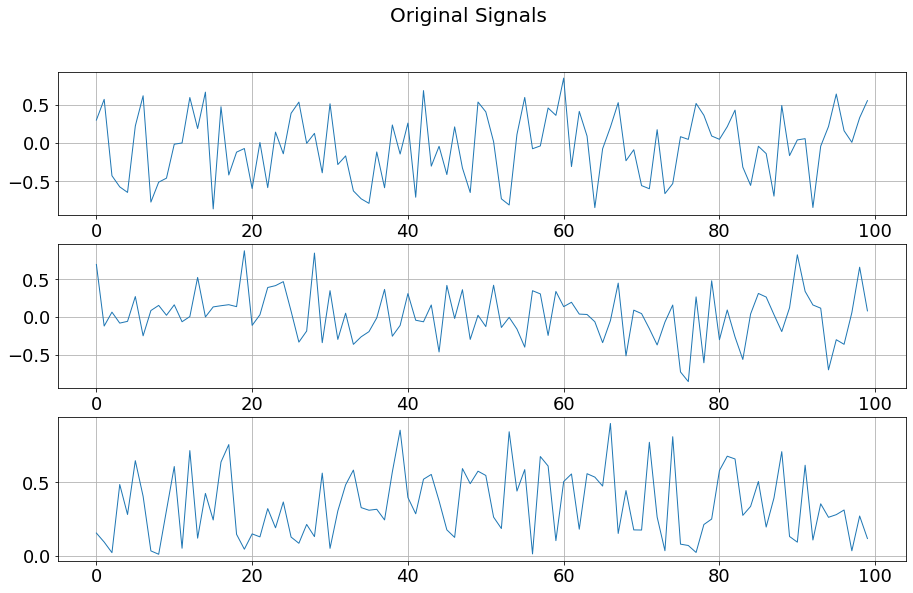

In [10]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)

# Visualization for Paper

In [11]:
# def SetPlotRC():
#     #If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
#     plt.rc('pdf',fonttype = 42)
#     plt.rc('ps',fonttype = 42)
# #     plt.rc('eps',fonttype = 1)

# def ApplyFont(ax, xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 19.0, x_ticks_text_size = 20, yticks_text_size = 20):

#     ticks = ax.get_xticklabels() + ax.get_yticklabels()
#     text_size = 20.0
# #     xlabel_text_size = 25.0
# #     ylabel_text_size = 25.0
# #     title_text_size = 19.0

#     for t in ticks:
#         t.set_fontname('Times New Roman')
#         t.set_fontsize(text_size)

#     txt = ax.get_xlabel()
#     txt_obj = ax.set_xlabel(txt)
#     txt_obj.set_fontname('Times New Roman')
#     txt_obj.set_fontsize(xlabel_text_size)

#     txt = ax.get_ylabel()
#     txt_obj = ax.set_ylabel(txt)
#     txt_obj.set_fontname('Times New Roman')
#     txt_obj.set_fontsize(ylabel_text_size)

#     txt = ax.get_xticks()
#     txt_xlabel = txt
# #     txt_obj = ax.set_xticks(txt)
#     txt_obj.set_fontname('Times New Roman')
#     txt_obj.set_fontsize(x_ticks_text_size)

#     txt = ax.get_yticks()
# #     txt_obj = ax.set_yticks(txt)
#     txt_obj.set_fontname('Times New Roman')
#     txt_obj.set_fontsize(yticks_text_size)


#     txt = ax.get_title()
#     txt_obj = ax.set_title(txt)
#     txt_obj.set_fontname('Times New Roman')
#     txt_obj.set_fontsize(yticks_text_size)

In [12]:
# xlabel_text_size = 25.0
# ylabel_text_size = 25.0
# title_text_size = 25.0
# x_ticks_text_size = 45
# yticks_text_size = 25.0

# SetPlotRC()
# plt.figure(figsize = (20,5))
# plt.subplot(1,3,1)
# plt.scatter(S[0,:], S[1,:])
# plt.xlabel("$S_{:,1}$", fontsize = 25)
# plt.ylabel("$S_{:,2}$", fontsize = 25)
# plt.grid(linewidth=.2)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)
# plt.subplot(1,3,2)
# plt.scatter(S[0,:], S[2,:])
# plt.xlabel("$S_{:,1}$", fontsize = 25)
# plt.ylabel("$S_{:,3}$", fontsize = 25)
# plt.grid(linewidth=.2)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)
# plt.subplot(1,3,3)
# plt.scatter(S[1,:], S[2,:])
# plt.xlabel("$S_{:,2}$", fontsize = 25)
# plt.ylabel("$S_{:,3}$", fontsize = 25)
# plt.grid(linewidth=.2)
# plt.subplots_adjust(wspace=0.3, hspace=0.1)
# plt.suptitle("Scatter Plot of Source Components", fontsize = 30)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)

# plt.savefig('Pex_source_components.pdf', format='pdf')

In [13]:
# SIR_list = modelWSM.SIR_list
# SNR_list = modelWSM.SNR_list
# D1minlist = modelWSM.D1minlist
# D2minlist = modelWSM.D2minlist

In [14]:
# import matplotlib.pyplot as pl

In [15]:
# xlabel_text_size = 45.0
# ylabel_text_size = 45.0
# title_text_size = 45.0
# x_ticks_text_size = 45
# yticks_text_size = 45

# debug_iteration_point = "10K"
# SetPlotRC()
# pl.figure(figsize = (40,30))
# pl.subplot(2,2,1)
# pl.plot(np.array(SIR_list), linewidth = 5)
# pl.xlabel("Number of Iterations / {}".format(debug_iteration_point), fontsize = 45)
# pl.ylabel("SINR (dB)", fontsize = 45)
# pl.title("SINR Behavior", fontsize = 45)
# pl.grid()
# pl.xticks(fontsize=45)
# pl.yticks(fontsize=45)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)
# pl.subplot(2,2,2)
# pl.plot(np.array(SNR_list), linewidth = 5)
# pl.grid()
# pl.title("Component SNR Behavior", fontsize = 45)
# pl.ylabel("SNR (dB)", fontsize = 45)
# pl.xlabel("Number of Iterations / {}".format(debug_iteration_point), fontsize = 45)
# pl.xticks(fontsize=45)
# pl.yticks(fontsize=45)
# pl.legend(["Source 1", "Source 2", "Source 3"],fontsize = "large", prop={'size': 60})
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)

# pl.subplot(2,2,3)
# pl.plot(np.array(D1minlist), linewidth = 5)
# pl.grid()
# pl.title("Diagonal Values of D1", fontsize = 45)
# pl.xlabel("Number of Iterations / {}".format(debug_iteration_point), fontsize = 45)
# pl.xticks(fontsize=45)
# pl.yticks(fontsize=45)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)

# pl.subplot(2,2,4)
# pl.plot(np.array(D2minlist), linewidth = 5)
# pl.grid()
# pl.title("Diagonal Values of D2", fontsize = 45)
# pl.xlabel("Number of Iterations / {}".format(debug_iteration_point), fontsize = 45)
# pl.xticks(fontsize=45)
# pl.yticks(fontsize=45)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)

# pl.savefig('Pex_example_SINRConvergence.pdf', format='pdf')

In [16]:
# xlabel_text_size = 25.0
# ylabel_text_size = 10.0
# title_text_size = 30.0
# x_ticks_text_size = 45
# yticks_text_size = 45

# SetPlotRC()
# plt.figure(figsize = (20,5))
# plt.subplot(1,3,1)
# plt.scatter(S[0,:], S[1,:])
# plt.xlabel("$S_{:,1}$", fontsize = 25)
# plt.ylabel("$S_{:,2}$", fontsize = 25)
# plt.grid(linewidth=.2)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)
# plt.subplot(1,3,2)
# plt.scatter(S[0,:], S[2,:])
# plt.xlabel("$S_{:,1}$", fontsize = 25)
# plt.ylabel("$S_{:,3}$", fontsize = 25)
# plt.grid(linewidth=.2)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)
# plt.subplot(1,3,3)
# plt.scatter(S[1,:], S[2,:])
# plt.xlabel("$S_{:,2}$", fontsize = 25)
# plt.ylabel("$S_{:,3}$", fontsize = 25)
# plt.grid(linewidth=.2)

# plt.suptitle("Scatter Plot of Source Components", fontsize = 30)
# ApplyFont(pl.gca(),xlabel_text_size, ylabel_text_size, title_text_size, x_ticks_text_size, yticks_text_size)

# # plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 1200)